In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler,normalize
from sklearn.cluster import estimate_bandwidth
/#les algos de classification non-supervisée
import scipy.cluster.hierarchy as shc
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
DS = pd.read_csv('D:/Université Lorraine/Synthèse/Task2_CC GENERAL.csv')
DS.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


In [9]:
print(' Ce data set contient {} lignes et {} colonne.\n'.format(DS.shape[0],DS.shape[1]))
DS.info()

 Ce data set contient 8950 lignes et 18 colonne.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX   

In [5]:
#Il faut préparer le Dataset en éliminant toutes les valeurs null
def null_values(DS):
    nv=pd.DataFrame(DS.isnull().sum()).rename(columns={0:'Missing_Records'})
    return nv[nv.Missing_Records>0].sort_values('Missing_Records', ascending=False)
null_values(DS)

,Missing_Records
MINIMUM_PAYMENTS,313
CREDIT_LIMIT,1


In [6]:
DS['MINIMUM_PAYMENTS']=DS['MINIMUM_PAYMENTS'].fillna(DS.MINIMUM_PAYMENTS.mean())
DS['CREDIT_LIMIT']=DS['CREDIT_LIMIT'].fillna(DS.CREDIT_LIMIT.mean())
null_values(DS).sum()

Missing_Records    0
dtype: int64

In [10]:
#Supprimer la colonne qualitative
DS=DS.drop('CUST_ID', axis=1)

In [11]:

# There are lots of outliers in columns but we will not apply winsorize or another methods to them.Because we may have information loss.
# They may represent another clusters.
Q1 = DS.quantile(0.25)
Q3 = DS.quantile(0.75)
IQR = Q3 - Q1
((DS[DS.columns ]< (Q1 - 1.5 * IQR)) | (DS[DS.columns] > (Q3 + 1.5 * IQR))).sum()

BALANCE                              695
BALANCE_FREQUENCY                   1493
PURCHASES                            808
ONEOFF_PURCHASES                    1013
INSTALLMENTS_PURCHASES               867
CASH_ADVANCE                        1030
PURCHASES_FREQUENCY                    0
ONEOFF_PURCHASES_FREQUENCY           782
PURCHASES_INSTALLMENTS_FREQUENCY       0
CASH_ADVANCE_FREQUENCY               525
CASH_ADVANCE_TRX                     804
PURCHASES_TRX                        766
CREDIT_LIMIT                         248
PAYMENTS                             808
MINIMUM_PAYMENTS                     774
PRC_FULL_PAYMENT                    1474
TENURE                              1366
dtype: int64

In [12]:
# StandardScaler nous permet de faire la Standardisation, c'est indisponsable car en général, 
#un ensemble de données contient des variables d'échelle différente.
scaler=StandardScaler()
DS_scl=scaler.fit_transform(DS)
#Normalisation des données
norm=normalize(DS_scl)
DS_norm=pd.DataFrame(norm)

In [13]:
est_bandwidth = estimate_bandwidth(DS_norm,quantile=0.1,n_samples=10000)
mean_shift = MeanShift(bandwidth= est_bandwidth, bin_seeding=True).fit(DS_norm)
labels_unique=np.unique(mean_shift.labels_)
n_clusters_=len(labels_unique)
print("Nombre de clusters esimé : %d" % n_clusters_)

Nombre de clusters esimé : 3


In [14]:

print('Silhouette Score for MeanShift:'+str(metrics.silhouette_score(DS_norm,mean_shift.labels_,metric='euclidean').round(3)))
print('Davies Bouldin Score for MeanShift:'+str(metrics.davies_bouldin_score(DS_norm,mean_shift.labels_).round(3)))

Silhouette Score for MeanShift:0.181
Davies Bouldin Score for MeanShift:2.114


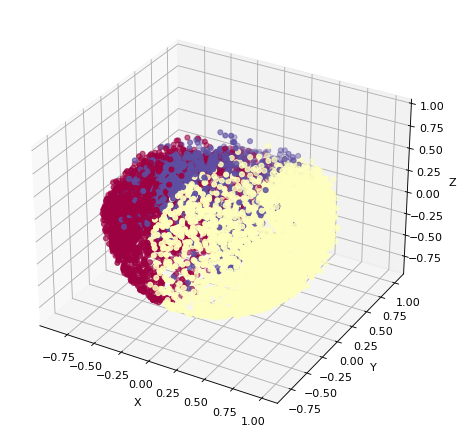

In [15]:
#On affiche les résultats dans un graphe de 3 dimensions mais il faut appliquer ACP pour avoir le résultat final
pca = PCA(n_components=3).fit_transform(DS_norm)
fig = plt.figure(figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")
ax.scatter3D(pca.T[0],pca.T[1],pca.T[2],c=mean_shift.labels_, cmap='Spectral')

xLabel = ax.set_xlabel('X')
yLabel = ax.set_ylabel('Y')
zLabel = ax.set_zlabel('Z')

In [ ]:
#modele = MeanShift(bandwidth= est_bandwidth, bin_seeding=True)
#modele.fit(DS_norm)
#modele.predict(DS_norm)
#ax.scatter(DS_norm.iloc[:,0], DS_norm.iloc[:,1], c = modele.fit(DS_norm))

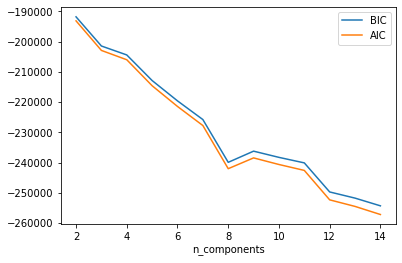

In [16]:
models = [GaussianMixture(n,covariance_type='tied', random_state=123).fit(DS_norm) for n in range(2,15)]
plt.plot(range(2,15), [m.bic(DS_norm) for m in models], label='BIC')
plt.plot(range(2,15), [m.aic(DS_norm) for m in models], label='AIC')
plt.legend()
plt.xlabel('n_components')
plt.show()

In [17]:
parameters=['full','tied','diag','spherical']
n_clusters=np.arange(1,21)
results_=pd.DataFrame(columns=['Covariance Type','Number of Cluster','Silhouette Score','Davies Bouldin Score'])
for i in parameters:
    for j in n_clusters:
        gmm_cluster=GaussianMixture(n_components=j,covariance_type=i,random_state=123)
        clusters=gmm_cluster.fit_predict(DS_norm
)
        if len(np.unique(clusters))>=2:
          results_=results_.append({"Covariance Type":i,'Number of Cluster':j,"Silhouette Score":metrics.silhouette_score(DS_norm
,clusters),
                                    'Davies Bouldin Score':metrics.davies_bouldin_score(DS_norm,clusters)}
                                   ,ignore_index=True)

In [18]:
display(results_.sort_values(by=["Silhouette Score"], ascending=False)[:5])

,Covariance Type,Number of Cluster,Silhouette Score,Davies Bouldin Score
57,spherical,2,0.225882,1.788540
19,tied,2,0.221231,1.820339
60,spherical,5,0.207279,1.558893
59,spherical,4,0.205902,1.713049
38,diag,2,0.203435,1.861149


In [22]:
gmm_cluster=GaussianMixture(n_components=5,covariance_type="spherical",random_state=123)
gmm_cluster.fit(DS_norm)
gmm_labels = gmm_cluster.predict(DS_norm)

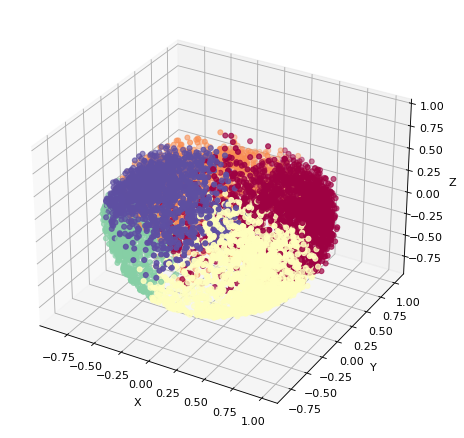

In [23]:
fig = plt.figure(figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")
ax.scatter3D(pca.T[0],pca.T[1],pca.T[2],c=gmm_labels,cmap='Spectral')

xLabel = ax.set_xlabel('X')
yLabel = ax.set_ylabel('Y')
zLabel = ax.set_zlabel('Z')

In [21]:
#DBSCAN
results=pd.DataFrame(columns=['Eps','Min_Samples','Number of Cluster','Silhouette Score'])
for i in range(1,12):
  for j in range(1,12):
      dbscan_cluster = DBSCAN(eps=i*0.2, min_samples=j)
      clusters=dbscan_cluster.fit_predict(DS_norm)
      if len(np.unique(clusters))>2:
          results=results.append({'Eps':i*0.2,
                        'Min_Samples':j,
                        'Number of Cluster':len(np.unique(clusters)),
                        'Silhouette Score':metrics.silhouette_score(DS_norm,clusters),
                        'Davies Bouldin Score':metrics.davies_bouldin_score(DS_norm,clusters)}, ignore_index=True)

In [24]:
results.sort_values('Silhouette Score',ascending=False)[:5]

,Eps,Min_Samples,Number of Cluster,Silhouette Score,Davies Bouldin Score
16,0.4,6.0,3.0,-0.033530,4.460939
18,0.6,2.0,4.0,-0.046250,3.857114
14,0.4,4.0,5.0,-0.122670,3.361897
15,0.4,5.0,5.0,-0.124499,3.304983
10,0.2,11.0,18.0,-0.238821,1.344078


In [25]:
dbscan_cluster = DBSCAN(eps=0.4, min_samples=4)
db_clusters=dbscan_cluster.fit_predict(DS_norm)

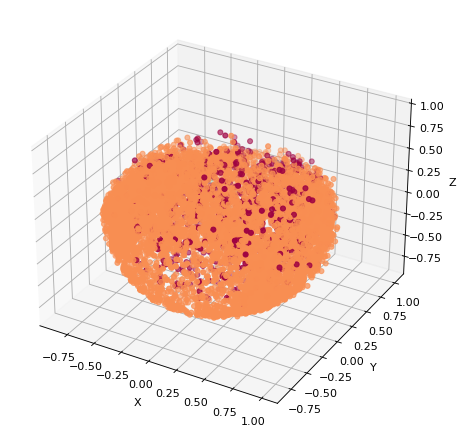

In [26]:
fig = plt.figure(figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")
ax.scatter3D(pca.T[0],pca.T[1],pca.T[2],c=db_clusters,cmap='Spectral')

xLabel = ax.set_xlabel('X')
yLabel = ax.set_ylabel('Y')
zLabel = ax.set_zlabel('Z')

In [27]:
algorithms=["DBSCAN","Gaussian Mixture Model","MeanShift"]

# Silhouette Score
ss=[metrics.silhouette_score(DS_norm,db_clusters),metrics.silhouette_score(DS_norm,gmm_labels),metrics.silhouette_score(DS_norm,mean_shift.labels_)]

# Davies Bouldin Score
db=[metrics.davies_bouldin_score(DS_norm,db_clusters),metrics.davies_bouldin_score(DS_norm,gmm_labels),metrics.davies_bouldin_score(DS_norm,mean_shift.labels_)]

In [28]:
comprsn={"Algorithms":algorithms,"Davies Bouldin":db,"Silhouette Score":ss}
compdf=pd.DataFrame(comprsn)
display(compdf.sort_values(by=["Silhouette Score"], ascending=False))

,Algorithms,Davies Bouldin,Silhouette Score
1,Gaussian Mixture Model,1.558893,0.207279
2,MeanShift,2.114327,0.180770
0,DBSCAN,3.361897,-0.122670


In [29]:
DS['Clusters']=list(gmm_labels)
customers=pd.DataFrame(DS['Clusters'].value_counts()).rename(columns={'Clusters':'Nombre de Clusters'})
customers.T

,1,0,2,3,4
Nombre de Clusters,2240,2085,1956,1412,1257


In [30]:
means=pd.DataFrame(DS.describe().loc['mean'])
means.T.iloc[:,[0,1,6,8,9,11,12,16]].round(1)

,BALANCE,BALANCE_FREQUENCY,PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,PURCHASES_TRX,CREDIT_LIMIT,TENURE
mean,1564.5,0.9,0.5,0.4,0.1,14.7,4494.4,11.5


In [32]:
DS.set_index('Clusters')
grouped=DS.groupby(by='Clusters').mean().round(1)
grouped.iloc[:,[0,1,6,8,9,11,12,16]]

,BALANCE,BALANCE_FREQUENCY,PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,PURCHASES_TRX,CREDIT_LIMIT,TENURE
Clusters,,,,,,,,
0,1855.8,1.0,0.9,0.5,0.1,39.6,6741.5,11.8
1,3247.1,0.9,0.2,0.1,0.4,4.6,5806.5,11.1
2,549.3,0.9,0.9,0.8,0.0,16.2,2827.6,11.5
3,1167.1,1.0,0.1,0.0,0.1,1.5,2329.1,11.9
4,108.9,0.4,0.2,0.2,0.0,3.9,3455.3,11.5


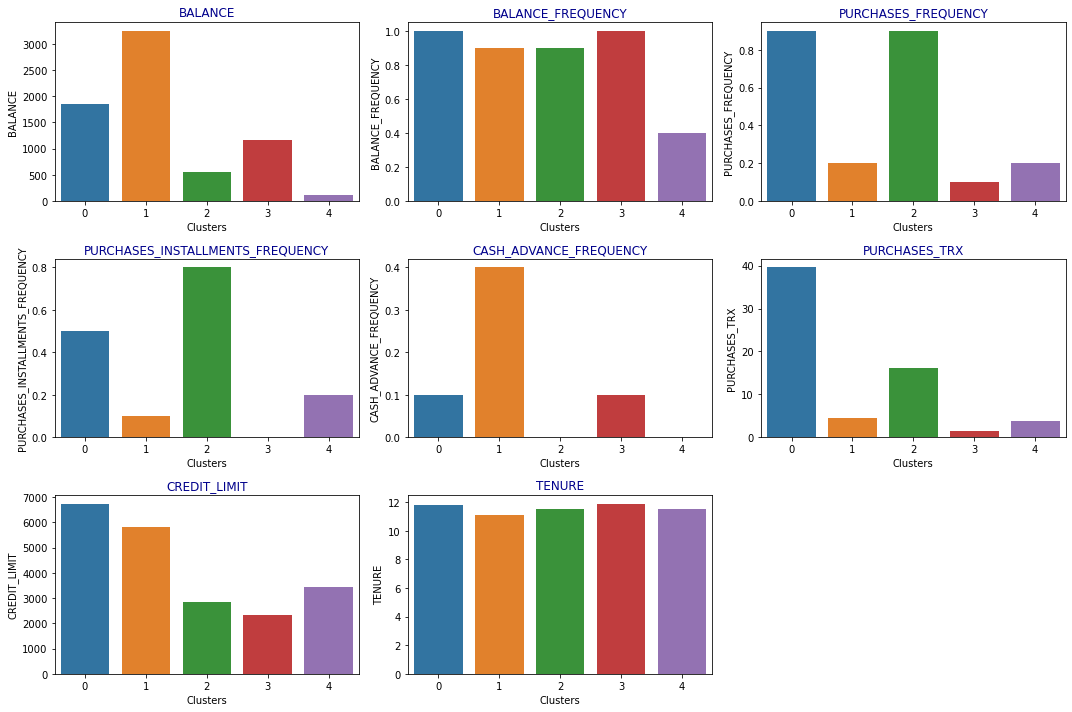

In [33]:
features=["BALANCE","BALANCE_FREQUENCY","PURCHASES_FREQUENCY","PURCHASES_INSTALLMENTS_FREQUENCY","CASH_ADVANCE_FREQUENCY","PURCHASES_TRX","CREDIT_LIMIT","TENURE"]
plt.figure(figsize=(15,10))
for i,j in enumerate(features):
    plt.subplot(3,3,i+1)
    sns.barplot(grouped.index,grouped[j])
    plt.title(j,fontdict={'color':'darkblue'})
plt.tight_layout()
plt.show()